In [302]:
import json
import numpy as np
from tqdm import tqdm
import glob as glob
import matplotlib.pyplot as plt
from scipy.stats import zscore, mannwhitneyu, ttest_ind, ks_2samp, wilcoxon, ranksums
import pybedtools as pbt
from IPython.display import clear_output
from ipyparallel import Client
import seaborn.apionly as sns

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

In [3]:
gencode_data = json.load(open('../data/annotation/hg19_gencode.json'))
gene_strand = {}
for i in gencode_data:
    g = gencode_data[i]['gene_name']
    s = gencode_data[i]['strand'] 
    if gencode_data[i]['chrom'] in chroms:
        if g in gene_strand:
            if gene_strand[g] != s:
                pass
        else:
            gene_strand[g] = s
len(gene_strand)

58171

In [4]:
chrom_wise_gene_locus_map = {x:{} for x in chroms}
phendc3_up_genes = []
phendc3_down_genes = []
with open('../data/ligands_rna_seq/GSE60630_phendc3_ht1080') as h:
    next(h)
    for l in h:
        c = l.rstrip('\n').split('\t')
        chrom = c[3].split(':')[0]
        if chrom in chrom_wise_gene_locus_map and c[2] in gene_strand:
            chrom_wise_gene_locus_map[chrom][c[2]] = [
                int(x) for x in c[3].split(':')[1].split('-')] + [gene_strand[c[2]]]
            if float(c[12]) < 0.05:
                if float(c[9]) > np.log2(1.5):
                    phendc3_up_genes.append(c[2])
                elif float(c[9]) < np.log2(0.5):
                    phendc3_down_genes.append(c[2])
len(chrom_wise_gene_locus_map), len(phendc3_up_genes), len(phendc3_down_genes)

(24, 1594, 718)

(5, 0)


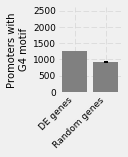

[1270, 917.26999999999998] 1.38454326425 (5, 0) MannwhitneyuResult(statistic=206.0, pvalue=0.046412142247541061)
(15, 0)


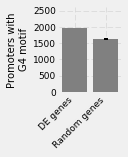

[1977, 1626.02] 1.21585220354 (15, 0) MannwhitneyuResult(statistic=229.0, pvalue=0.11385430944653702)
(25, 0)


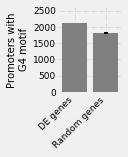

[2129, 1812.54] 1.17459476756 (25, 0) MannwhitneyuResult(statistic=237.0, pvalue=0.14885025128924356)
(5, 3)


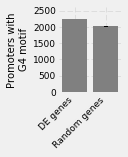

[2232, 2011.99] 1.10934945005 (5, 3) MannwhitneyuResult(statistic=253.0, pvalue=0.23841903063470776)
(15, 3)


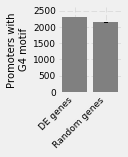

[2299, 2139.1500000000001] 1.07472594255 (15, 3) MannwhitneyuResult(statistic=262.0, pvalue=0.29950823396296333)
(25, 3)


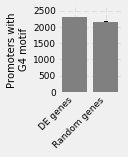

[2305, 2161.7800000000002] 1.06625095986 (25, 3) MannwhitneyuResult(statistic=262.5, pvalue=0.30309020794946584)


In [23]:
def calc_overlap(chrom):
    import pybedtools as pbt
    import numpy as np

    def load_g4_bed():
        g4_bed = []
        with open('/home/parashar/scratch/quadruplexes/hg19/g3_%s_%s_%s_nov.bed' %
                  (loop, bulge, chrom)) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                s = '+' if c[4] == 'G' else '-'
                g4_bed.append('\t'.join(map(str, [c[0], c[1], c[2], '.', '0', s])))
        g4_bed = pbt.BedTool('\n'.join(g4_bed), from_string=True)
        return g4_bed

    def load_de_non_de_genes():
        de_bed = []
        rest_bed = []
        for gene, info in gene_info[chrom].items():
            if info[2] == '+':
                bed_line = '\t'.join(map(str, [chrom, info[0]-offset, info[0]+offset,
                                               gene, '0', info[2]]))
            else:
                bed_line = '\t'.join(map(str, [chrom, info[1]-offset, info[1]+offset,
                                               gene, '0', info[2]]))
            if gene in de_genes:
                de_bed.append(bed_line)
            else:
                rest_bed.append(bed_line)

        de_bed = pbt.BedTool('\n'.join(de_bed), from_string=True)
        rest_bed = pbt.BedTool('\n'.join(rest_bed), from_string=True)
        return de_bed, rest_bed

    g4_bed = load_g4_bed()
    de_bed, rest_bed = load_de_non_de_genes()
    g4_de = de_bed.intersect(g4_bed, u=True).count()
    
    rest_genes = []
    for i in rest_bed:
        rest_genes.append(str(i.name))
    rest_genes = np.array(list(set(rest_genes)))
    g4_rest = rest_bed.intersect(g4_bed, wo=True)
    g4_rest_genes = []
    for i in g4_rest:
        g4_rest_genes.append(str(i.name))
    g4_rest_genes = np.array(list(set(g4_rest_genes)))
    
    g4_rests = []
    for i in range(100):
        random_genes = set([rest_genes[np.random.randint(len(rest_genes))]
                        for x in range(len(de_bed))])
        g4_rests.append(len(random_genes.intersection(g4_rest_genes)))
    
    return g4_de, g4_rests

offset = 500
configs = [(5, 0), (15, 0), (25, 0), (5, 3), (15, 3), (25, 3)]

for config in configs:
    loop = str(config[0])
    bulge = str(config[1])

    _ = DVIEW.push(dict(
        de_genes=phendc3_up_genes+phendc3_down_genes,
        gene_info=chrom_wise_gene_locus_map,
        loop=loop,
        bulge=bulge,
        offset=offset
    ))
    
    print (config)
    
    res = DVIEW.map_sync(calc_overlap, chroms)
    g4_de, g4_rests = [], []
    for i in res:
        g4_de.append(i[0])
        g4_rests.append(i[1])
    g4_de = np.array(g4_de)
    g4_rests = np.array(g4_rests)
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2.4))
    x = [1,2]
    y = [g4_de.sum(), g4_rests.sum(axis=0).mean()]
    ax.bar(x, y, yerr=[0, g4_rests.sum(axis=0).std()], color='grey')
    ax.set_ylabel('Promoters with\nG4 motif', fontsize=10)
    ax.set_xticklabels(['', 'DE genes', 'Random genes'], fontsize=9, rotation=45, ha='right')
    ax.set_ylim((0, 2600))
    ax.set_yticks([x for x in range(0, 2600, 500)])
    clean_axis(ax)
    plt.tight_layout()
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.png' % (config[0], config[1]), dpi=300,
                transparent=True, edgecolor='none')
    plt.savefig('../images/phendc3_rna_seq_G4_%d_%d.svg' % (config[0], config[1]),
                transparent=True, edgecolor='none')
    plt.show()
    print (y, y[0]/y[1], config, mannwhitneyu(g4_de, g4_rests.mean(axis=1)))

In [291]:
def load_scores(chrom, chrom_info, strand):
    fn = '../data/sniprq_scores/%s_%s.npy' % (chrom, strand)
    return np.load(fn, mmap_mode='r')

gene_names = []
snipr_scores = []
offset = 500
for chrom in chroms:
    print (chrom)
    temp = []
    pos_exp = load_scores(chrom, chrom_info, 'positive')
    neg_exp = load_scores(chrom, chrom_info, 'negative')
    for gene, info in chrom_wise_gene_locus_map[chrom].items():
        gene_names.append(gene)
        if info[2] == '+':
            pos_score = pos_exp[info[0] - offset : info[0] + offset]
            neg_score = neg_exp[info[0] - offset : info[0] + offset]
        else:
            pos_score = pos_exp[info[1] - offset : info[1] + offset][::-1]
            neg_score = neg_exp[info[1] - offset : info[1] + offset][::-1]
        temp.append(np.array(pos_score) + np.array(neg_score))
    snipr_scores.append(np.array(temp))
    clear_output()

In [292]:
de_snipr = []
rest_snipr = []
for n,chrom in enumerate(chroms):
    de_temp = []
    rest_temp = []
    for i,gene in enumerate(chrom_wise_gene_locus_map[chrom]):
        if gene in phendc3_up_genes or gene in phendc3_down_genes:
            de_temp.append(snipr_scores[n][i])
        else:
            rest_temp.append(snipr_scores[n][i])
    de_snipr.extend(de_temp)
    rest_snipr.extend(rest_temp)
random_rest_snipr = [rest_snipr[np.random.randint(len(rest_snipr))] for 
                     x in range(len(de_snipr))]
de_snipr = np.array(de_snipr)
random_rest_snipr = np.array(random_rest_snipr)
len(de_snipr), len(rest_snipr), len(random_rest_snipr)

(2312, 18738, 2312)

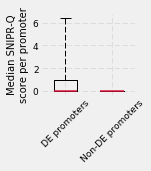

(MannwhitneyuResult(statistic=4499.5, pvalue=0.035618100508269079),
 2.0164466565678425,
 2312,
 2312)

In [414]:
a = np.array([np.median(x) for x in de_snipr])
b = np.array([np.median(x) for x in random_rest_snipr])

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([np.log2(a+1), np.log2(b+1)], sym='', whis=1000, widths=[0.5, 0.5], whiskerprops=whiskerprops,
           boxprops=boxprops, medianprops=medianprops)
    
ax.set_ylabel('Median SNIPR-Q\nscore per promoter', fontsize=10)
ax.set_xticklabels(['DE promoters', 'Non-DE promoters'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MEDIAN.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MEDIAN.svg', transparent=True, edgecolor='none')

plt.show()
mannwhitneyu(a[:100], b[:100]), np.mean(a)/np.mean(b), len(a), len(b)

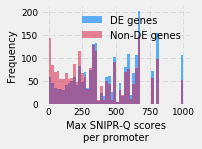

(MannwhitneyuResult(statistic=2108547.0, pvalue=8.5814024106425829e-36),
 1.2593929804372843)

In [422]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.3))

a = [np.max(x) for x in de_snipr]
b = [np.max(x) for x in random_rest_snipr]

ax.hist(a, alpha=0.7, bins=50, color='dodgerblue', label='DE genes')
ax.hist(b, alpha=0.5, bins=50, color='crimson', label='Non-DE genes')
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Max SNIPR-Q scores\nper promoter', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MAX.svg',
            transparent=True, edgecolor='none')
plt.show()
mannwhitneyu(a, b), np.mean(a)/np.mean(b)

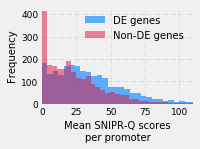

(MannwhitneyuResult(statistic=1983449.0, pvalue=2.2328088437537869e-52),
 1.4152126889020489)

In [425]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.3))

a = [np.mean(x) for x in de_snipr]
b = [np.mean(x) for x in random_rest_snipr]
ax.hist(a, alpha=0.7, bins=50, color='dodgerblue', label='DE genes')
ax.hist(b, alpha=0.5, bins=50, color='crimson', label='Non-DE genes')
ax.legend(frameon=False, fontsize=10)
ax.set_xlabel('Mean SNIPR-Q scores\nper promoter', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_xlim((0, 110))
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_promoter_wise_MEAN.svg',
            transparent=True, edgecolor='none')
plt.show()
mannwhitneyu(a, b), np.mean(a)/np.mean(b)

(1000,) (1000,)
33.9058559689 23.9581345156 1.4152126889


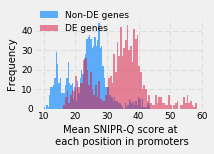

(MannwhitneyuResult(statistic=189393.5, pvalue=3.8432867012404671e-128),
 1.4152126889020487)

In [424]:
a = np.array(de_snipr)
r = np.array(random_rest_snipr)
a = a.sum(axis=0)/len(a)
r = r.sum(axis=0)/len(r)

print (a.shape, r.shape)
print (a.mean(), r.mean(), a.mean()/r.mean())

fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.2))

ax.hist(r, bins=80, alpha=0.7, color='dodgerblue', label='Non-DE genes')
ax.hist(a, bins=80, alpha=0.5, color='crimson', label='DE genes')
ax.set_xlabel('Mean SNIPR-Q score at\n each position in promoters', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.legend(frameon=False, loc= (0, 0.8), fontsize=9)
clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_snipr_position_wise.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_snipr_position_wise.svg', transparent=True, edgecolor='none')

plt.show()

mannwhitneyu(a, r), np.mean(a)/np.mean(r)

In [6]:
offset = 500
sequences = []
hunter_genes = []
for chrom in chroms:
    print (chrom)
    chrom_seq = ''.join([x.rstrip('\n').upper() for x in open(
        '/home/parashar/scratch/hg19_resource/chromosomes/%s.fa' % chrom).readlines()[1:]])
    for gene, info in chrom_wise_gene_locus_map[chrom].items():
        hunter_genes.append(gene)
        if info[2] == '+':
            seq = chrom_seq[info[0] - offset : info[0] + offset]
        else:
            seq = chrom_seq[info[1] - offset : info[1] + offset][::-1]
        sequences.append(seq)
    clear_output()
with open('../data/ligands_rna_seq/promoter_sequences.seq', 'w') as OUT:
    OUT.write("\n".join(sequences))

In [ ]:
hunter_script = '/home/parashar/scratch/quadcomb/scripts/G4Hunter.r'
in_fn = '../data/ligands_rna_seq/promoter_sequences.seq'
out_fn = '../data/ligands_rna_seq/hunter_scores.txt'
! Rscript $hunter_script $in_fn $out_fn
clear_output()

In [130]:
hunter_scores = []
with open(out_fn) as h:
    next(h)
    for l in h:
        c = l.rstrip('\n').split('\t')
        hunter_scores.append(abs(float(c[1])))
len(hunter_scores) ,len(hunter_genes)

(21050, 21050)

In [131]:
de_hunter = []
rest_hunter = []
for gene,s in zip(hunter_genes, hunter_scores):
    if gene in phendc3_up_genes or gene in phendc3_down_genes:
        de_hunter.append(s)
    else:
        rest_hunter.append(s)
de_hunter = np.array(de_hunter)
rest_hunter = np.array(rest_hunter)

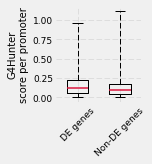

(MannwhitneyuResult(statistic=2318825.0, pvalue=3.1979921440508951e-15),
 1.233745261458034)

In [420]:
a = de_hunter
b = rest_hunter
b = np.array([b[np.random.randint(len(b))] for x in range(len(a))])

fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, b], sym='', whis=10, widths=[0.5, 0.5], whiskerprops=whiskerprops,
          boxprops=boxprops, medianprops=medianprops)

ax.set_ylabel('G4Hunter\nscore per promoter', fontsize=10)
ax.set_xticklabels(['DE genes', 'Non-DE genes'], rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/phendc3_rna_seq_hunter_promoter_wise.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/phendc3_rna_seq_hunter_promoter_wise.svg', transparent=True, edgecolor='none')

plt.show()
mannwhitneyu(a, b), a.mean()/b.mean()